# CS 329E Term Project (Fall 2021)

## Predicting the Number of Active COVID-19 Cases in a Country Based on its Total COVID-19 Tests Administered and Total Number of Positive Cases

## By: Sakif Islam (isi72)

In [1]:
# import standard headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# import sklearn LinearRegression for the model
from sklearn.linear_model import LinearRegression

# import yellowbrick to use its ResidualsPlot function
# may need to go into Terminal and download yellowbrick if you don't have the library installed
## > pip install yellowbrick
### this is the library Professor Teymourian used in his Code-Example-011-Linear-Regression-Residual-Plots.ipynb on Github
from yellowbrick.regressor import ResidualsPlot

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

## Information on Dataset

This project uses COVID-19 data from each country in the world as of November 23, 2021 (source: https://www.worldometers.info/coronavirus/#countries / download: https://www.kaggle.com/anandhuh/covid19-in-world-countrieslatest-data). It contains data on the total cases of COVID-19 in the country, the total deaths, the total recovered, active cases, total tests, and the populations of each country. More information about the attributes are listed below.

**Dataset Attribute Information**
- Country - Name of world countries
- Total Cases - Total number of COVID-19 cases
- Total Deaths - Total number of Deaths
- Total Recovered - Total number of recovered cases
- Active Cases - Total number of active cases
- Total Cases/1 mil population- Total Cases per 1 million of the population
- Death/1 mil population - Total Deaths per 1 million of the population
- Total Tests - Total number of COVID-19 tests done
- Tests/1 mil population - COVID-19 tests done per 1 million of the population
- Population - Population of the country

In [2]:
# import the dataset as a pandas DataFrame and visualize it
df = pd.read_csv('covid_data.csv')
df

Country  Total Cases  Total Deaths  Total Recovered  Active Cases  \
0    Afghanistan       157015          7305         140326.0        9384.0   
1        Albania       196611          3049         185569.0        7993.0   
2        Algeria       209111          6026         143413.0       59672.0   
3        Andorra        16299           130          15646.0         523.0   
4         Angola        65033          1730          63123.0         180.0   
..           ...          ...           ...              ...           ...   
201    Venezuela       426014          5088         412440.0        8486.0   
202      Vietnam      1104835         23951         910276.0      170608.0   
203        Yemen         9967          1942           6781.0        1244.0   
204       Zambia       210073          3667         206316.0          90.0   
205     Zimbabwe       133674          4699         128465.0         510.0   

     Total Cases/1M population  Deaths/1M population  Total Tests  \
0                         3911                   182     786248.0   
1                        68424                  1061    1372360.0   
2                         4652                   134     230861.0   
3                       210481                  1679     193595.0   
4                         1897                    50    1166184.0   
..                         ...                   ...          ...   
201                      15041                   180    3359014.0   
202                      11210                   243   66125473.0   
203                        324                    63     265253.0   
204                      11000                   192    2691302.0   
205                       8815                   310    1569423.0   

     Tests/1M population  Population  
0                19585.0    40145225  
1               477604.0     2873425  
2                 5136.0    44950745  
3              2500032.0       77437  
4                34016.0    34283759  
..                   ...         ...  
201             118593.0    28323827  
202             670942.0    98556168  
203               8630.0    30737797  
204             140920.0    19098078  
205             103500.0    15163536  

[206 rows x 10 columns]

## Research Question: Can we predict the active number of COVID-19 cases in a country given its total number of COVID-19 tests administered and total cases of COVID-19?

The goal of this project is to determine if we can create a Multiple Linear Regression model that will allow us to predict the number of active COVID-19 cases in a specific country given data on its total number of COVID-19 tests administered and the total number of COVID-19 cases in that country. Being able to predict a value like this is super important, especially during pandemics, because it allows a country to determine its risk level and implement public health policies accordingly.

As mentioned previously, a Multiple Linear Regression (MLR) model will be utilized to achieve this goal. I expect that there need to be some transformations to the data to run a proper MLR, but in the end, it will provide us with a decent prediction on the number of active cases of COVID-19 in a country based on the parameters mentioned. My hope is that the R^2 value is somewhere between 55% and 75% which will indicate the model is better than predicting by pure chance alone.

The correctness of the model will be indicated by correctly meeting the assumptions of MLR and by the R^2 value. Meeting the assumptions of MLR is essential for valid interpretations and predictions using the model; if you don't meet the assumptions, then the model's predictions are unreliable. Next, a higher R^2 will indicate the model is useful and a valid R^2 (any positive value from 0 to 1) tells us the model was implemented successfully. Additionally, obtaining reasonable regression coefficients and visualizing a 3D plot that shows the hyperplane between the datapoints will be essential in determining the correctness of the model. If the hyperplane dissects the points reasonably, the model is correct given the data.

## Data Cleaning

In [3]:
# clean up the data and check to make sure the data makes sense

# check if total cases is greater than the entire population, this shouldn't be possible
index_tot_pop = df[(df['Total Cases'] > df['Population'])].index
# check if the active cases are greater than the total cases, this is impossible (at best they can be equal)
index_tot_act = df[(df['Total Cases'] < df['Active Cases'])].index
# check if the total deaths are greater than the total cases, this is impossible (at best they can be equal)
index_tot_death = df[(df['Total Cases'] < df['Total Deaths'])].index
# check if the total recovered is greater than the total cases, this shouldn't be possible
index_tot_recov = df[(df['Total Cases'] < df['Total Recovered'])].index
# check if there are any columns with missing data
nan_count = df.isna().sum()

# keep note of how many countries have populations less than 1M because their total cases per 1M and total tests
# per 1M are predicted and not actual data
index_pop1m = df[(df['Population'] < 1000000)].index

# print the number of indices of each to see if any data needs to be dropped
print('Indices Checks:', index_tot_pop.size, index_tot_act.size, index_tot_death.size, index_tot_recov.size)
print('\nNaN Check - \n{}'.format(nan_count))
print('\nCountries with Less than 1M Population:', index_pop1m.size)

Indices Checks: 0 0 0 0

NaN Check - 
Country                      0
Total Cases                  0
Total Deaths                 0
Total Recovered              5
Active Cases                 5
Total Cases/1M population    0
Deaths/1M population         0
Total Tests                  4
Tests/1M population          4
Population                   0
dtype: int64

Countries with Less than 1M Population: 49


### Discussion on Cleaning
*It appears that this dataset is already quite clean and doesn't need any more cleaning tasks to be completed before analysis, aside from removing some of the rows that are missing data (NaN). Since both 'Total Tests' and 'Active Cases' data will be used in the model, the rows with missing data in these columns will be dropped. The other 4 checks I implemented to see how clean the data was is a good indicator that the entire dataset is pretty clean and ready for implementation. It is important to realize that some countries have less than 1 million in population so their Total Cases per 1M and Total Tests per 1M are predictions based on their actual ratios with their current population. Using these columns as predictors in the data could skew the model so its best to stay away from using the per 1M data columns in a model.*

In [4]:
# drop the rows with missing data in 'Total Tests' and 'Active Cases'
df = df.dropna(axis=0, subset=['Active Cases', 'Total Tests'])

# get new NaN count and see if the correct rows were dropped
new_nan_count = df.isna().sum()
print(new_nan_count)

Country                      0
Total Cases                  0
Total Deaths                 0
Total Recovered              0
Active Cases                 0
Total Cases/1M population    0
Deaths/1M population         0
Total Tests                  0
Tests/1M population          0
Population                   0
dtype: int64


## Checking Multiple Linear Regression Assumptions

### Residual Plots

In [5]:
# Make residual plot to check constant variance and normality assumptions

# create x and y dataframes for residual plot
x_resid = df[['Total Cases', 'Total Tests']].values
y_resid = df['Active Cases'].values

# create model for residual plot and residual plot
model = LinearRegression()
resplot = ResidualsPlot(model)

# fit the residual plot and show it
resplot.fit(x_resid, y_resid)
resplot.show()

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

#### Constant Variance Assumption Violated
*This residual plot shows that the constant variance assumption is violated by this data, because there are very clear outliers and there is not the same amount of scatter or variation from left to right. It looks like the variation is increasing from left to right. This means a natural log transformation should be attempted on the data to see if it will meet the assumptions of MLR.*

#### Apply Transformation

In [6]:
# remove the chained assignment error
pd.set_option('mode.chained_assignment', None)

# create a df_transform to transform the data
df_transform = df[['Total Cases', 'Total Tests', 'Active Cases']]

# perform a natural log transformation on each column
df_transform.loc[:, 'Total Cases'] = np.log(df_transform['Total Cases'])
df_transform.loc[:, 'Total Tests'] = np.log(df_transform['Total Tests'])
df_transform.loc[:, 'Active Cases'] = np.log(df_transform['Active Cases'])

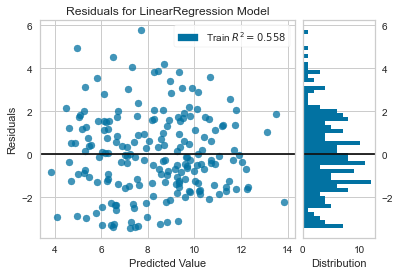

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [7]:
# create x and y with transformed data
x_transform = df_transform[['Total Cases', 'Total Tests']].values
y_transform = df_transform['Active Cases'].values

# create model and residual plot
model = LinearRegression()
resplot = ResidualsPlot(model)

# fit the plot and show it
resplot.fit(x_transform, y_transform)
resplot.show()

### Assumptions

**Linearity:** The scatter matrix plotted in the 'Correlation Matrix' section below shows that there is a roughly linear trend between the natural log of all the variables that will be used in the MLR. Therefore, linearity is met.

**Independence:** All of the observations in the dataset are independent. This means each country obtained their data independently. Also, each value corresponds to a unique individual and no individuals were counted twice in one country or once in one country and once in another. Therefore, independence is met.

**Constant Variance:** With the natural log transformation, we can see that the constant variance assumption is met. There is approximately equal amounts of scatter from left to right and there are no clear outliers or patterns in the data. Therefore, constant variance is met.

**Normality:** The right side of the residual plot shows the histogram of residuals which is used to determine normality. The residuals follow a roughly normal distribution so the normality assumption is met.

## Correlation Matrix

Pearson Correlation between ln(Total Cases) and ln(Total Tests): 0.8851184601254495
Pearson Correlation between ln(Total Cases) and ln(Active Cases): 0.7468788721804519
Pearson Correlation between ln(Total Tests) and ln(Active Cases): 0.6556191846899656


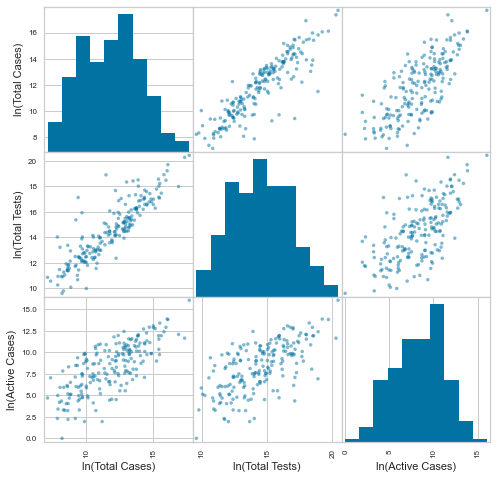

In [8]:
# create a dataframe with the distance, duration, and fare for a scatter matrix
scatter_matrix = df_transform[['Total Cases', 'Total Tests', 'Active Cases']]

# rename the columns
scatter_matrix = scatter_matrix.rename(columns={"Total Cases": "ln(Total Cases)", "Total Tests": "ln(Total Tests)", "Active Cases": "ln(Active Cases)"})

# plot a scatter matrix using pd.plotting for visualization
matrix_plots = pd.plotting.scatter_matrix(scatter_matrix, figsize=(8, 8), range_padding=0.05)
matrix_plots


# calculate and print the correlations between trip distance, travel time, and fare amount for discussion
cases_tests_corr = stats.pearsonr(scatter_matrix['ln(Total Cases)'], scatter_matrix['ln(Total Tests)'])[0]
cases_active_corr = stats.pearsonr(scatter_matrix['ln(Total Cases)'], scatter_matrix['ln(Active Cases)'])[0]
tests_active_corr = stats.pearsonr(scatter_matrix['ln(Total Tests)'], scatter_matrix['ln(Active Cases)'])[0]

print("Pearson Correlation between ln(Total Cases) and ln(Total Tests):", cases_tests_corr)
print("Pearson Correlation between ln(Total Cases) and ln(Active Cases):", cases_active_corr)
print("Pearson Correlation between ln(Total Tests) and ln(Active Cases):", tests_active_corr)

### Description of Correlations:

- ln(Total Cases) vs. ln(Total Tests): The correlation from the scatterplot appears to be somewhat linear with a strong, positive correlation. This correlation is confirmed by the Pearson Correlation Coefficient of 0.885 between the two variables which indicates a strong, linear, positive relationship. So as natural log of the total cases increase, the natural log of the total tests administered also seem to increase. This makes sense because the more cases a country has, the more tests they likely used to confirm that an individual has COVID-19.


- ln(Total Cases) vs. ln(Active Cases): The correlation from the scatterplot appears to be linear with a somewhat strong, positive correlation. This correlation is confirmed by the Pearson Correlation Coefficient of 0.747 between them which indicates a strong, linear, positive relationship. So as the natural log of total cases increases, the natural log of the number of active cases is also seen to increase which makes sense. More total cases means there would need to be more active cases at one point.


- ln(Total Tests) vs. ln(Active Cases): The correlation from the scatterplot also appears to be linear with a somewhat strong, positive correlation. This is confirmed by the Pearson Correlation Coefficient of 0.656 between them which indicates a strong, linear, positive relationship. So as natural log of total tests administered increases, the natural log of number of active cases is also seen to increase.

## Multiple Linear Regression Model (Interpretation and Visualization)

In [9]:
# use Scikit-learn to make a linear model and fit it with the x values and y values
# this regression model uses least squares regression to minimize the squares of the distances between the actual values and predicted values
casestests_active_regr = LinearRegression()
casestests_active_regr.fit(x_transform, y_transform)

# find the regression coefficients
slope_cases = casestests_active_regr.coef_[0]
slope_tests = casestests_active_regr.coef_[1]
intercept = casestests_active_regr.intercept_

# evaluate the model using R^2
r2 = model.score(x_transform, y_transform)

# print the regression coefficients, regression equation, and R^2
print('Regression Coefficients:')
print('-ln(Total Cases) Slope: {:5f}'.format(slope_cases))
print('-ln(Total Tests) Slope: {:5f}'.format(slope_tests))
print('-Intercept: {:5f}'.format(intercept))
print('\nMultiple Linear Regression Equation:')
print('ln(Active Cases) = {:.3f} * ln(Total Cases) + {:.3f} * ln(Total Tests) + {:.3f}'.format(slope_cases, slope_tests, intercept))
print('\nR^2 = {:.3f}'.format(r2))

Regression Coefficients:
-ln(Total Cases) Slope: 0.972478
-ln(Total Tests) Slope: -0.031262
-Intercept: -2.751029

Multiple Linear Regression Equation:
ln(Active Cases) = 0.972 * ln(Total Cases) + -0.031 * ln(Total Tests) + -2.751

R^2 = 0.558


### Interpretation

Interpretation of natural log transformed variables can be quite confusing and meaningless if done incorrectly, so I consulted this resource (https://cscu.cornell.edu/wp-content/uploads/83_logv.pdf) to correctly interpret the coefficients. When both the predictors and the response are log transformed, the coefficients are considered elasticities.

***ln(Total Cases) Slope: 0.972***
- For every 1% increase in the total COVID-19 cases in a country, the number of active cases in a country is predicted to increase by 0.972%.

***ln(Total Tests) Slope: -0.031***
- For every 1% increase in the total COVID-19 tests administered in a country, the number of active cases in a country is predicted to decrease by 0.031%.

***Intercept: -2.751***
- For a country with 0 natural log total cases and 0 natural log total tests administered, the natural log of the active cases in that country is predicted to be -2.751 ln(cases). 
- In other words, for a country with 1 total case and 1 total test (because e^0 = 1), the country's active number of cases will be 0.064 cases (e^-2.751).

***R^2: 0.558***
- 55.8% of the variability in the natural log of the number of active COVID-19 cases is accounted for by the natural log of the total tests and total cases variables included in the model.

### Visualization

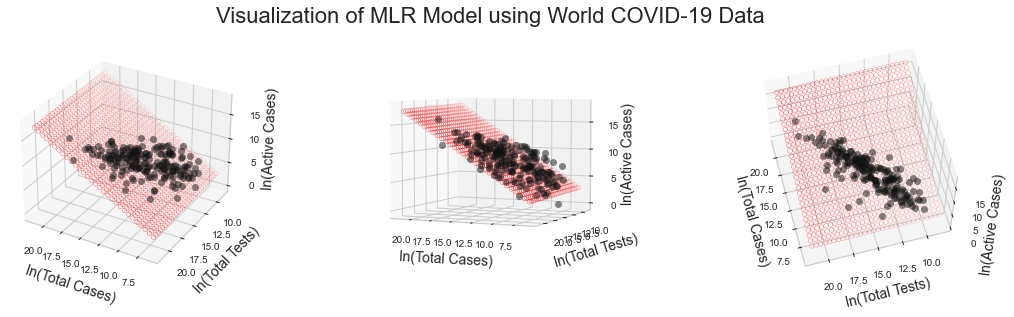

In [10]:
# visualize the model
# source: https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python
# code utilized as a guide, but changed to make my own

# obtain the x, y, and z values
x = x_transform[:, 0]
y = x_transform[:, 1]
z = y_transform

# obtain the axes for the plot
x_pred = np.linspace(np.amin(x) - 1, np.amax(y) + 1, 30)   # range of ln(Total Cases) values
y_pred = np.linspace(np.amin(y) - 1, np.amax(y) + 1, 30)  # range of ln(Total Tests) values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
predicted = casestests_active_regr.predict(model_viz)

# generate the plot with the correct axes, the data, and the hyperplane
fig = plt.figure(figsize=(16, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

# plot the data and label the axes
for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='red')
    ax.set_xlabel('\nln(Total Cases)', fontsize=14)
    ax.set_ylabel('\nln(Total Tests)', fontsize=14)
    ax.set_zlabel('ln(Active Cases)', fontsize=14)

# initialize 3 views of the plot for best visualization
ax1.view_init(elev=30, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

# give the plots a title
fig.suptitle('Visualization of MLR Model using World COVID-19 Data', fontsize=22)

fig.tight_layout()

As you can see in the visualization, it appears the hyperplane fits the data quite well. There are no obvious outliers or deviations from the data points and the hyperplane follows the general linear trend of the data points. Therefore, it appears the MLR created suitable regression coefficients and a moderately well fitted hyperplane.

## Improvements

One method to improve the results is to try different combinations of predictors and see if that improves the R^2 measure. A higher R^2 indicates that more of the variation in the dependent variable is explained by the independent variables.

### Implementation of Potential Improvements

In [11]:
# This function creates the MLR model, calculates the R^2 and prints the relevant info
def linear_regression(reg_df):
    # keep column names for x data
    x_col = []
    
    # apply natural log transformation to each column
    for column in reg_df.columns:
        reg_df.loc[:, column] = np.log(reg_df[column])
        if column != 'Active Cases':
            x_col.append(column)
    
    # get new x and y values
    reg_x = reg_df[x_col].values
    reg_y = reg_df['Active Cases'].values
    
    # create the model and fit it
    regr_model = LinearRegression()
    regr_model.fit(reg_x, reg_y)
    
    # find the regression coefficients
    slope1 = regr_model.coef_[0]
    slope2 = regr_model.coef_[1]
    regr_intercept = regr_model.intercept_

    # evaluate the model using R^2
    r2_new = model.score(reg_x, reg_y)

    # print the regression coefficients, regression equation, and R^2
    print('Regression Coefficients:')
    print('-ln(Total Cases) Slope: {:5f}'.format(slope1))
    print('-ln(Total Tests) Slope: {:5f}'.format(slope2))
    print('-Intercept: {:5f}'.format(regr_intercept))
    print('\nMultiple Linear Regression Equation:')
    print('ln(Active Cases) = {:.3f} * ln({}) + {:.3f} * ln({}) + {:.3f}'.format(slope1, x_col[0], slope2, x_col[1], regr_intercept))
    print('\nR^2 = {:.3f}'.format(r2_new))

In [12]:
# create a new df with different predictors to see if it improves the model
new_df = df[['Total Cases', 'Total Deaths', 'Active Cases']]

# find new regression coefficients and R^2 using new_df
linear_regression(new_df)

Regression Coefficients:
-ln(Total Cases) Slope: 1.135502
-ln(Total Tests) Slope: -0.179311
-Intercept: -3.770042

Multiple Linear Regression Equation:
ln(Active Cases) = 1.136 * ln(Total Cases) + -0.179 * ln(Total Deaths) + -3.770

R^2 = 0.553


In [13]:
# create a new df with different predictors to see if it improves the model
new_df = df[['Total Cases', 'Total Recovered', 'Active Cases']]

# find new regression coefficients and R^2 using new_df
linear_regression(new_df)

Regression Coefficients:
-ln(Total Cases) Slope: 2.330946
-ln(Total Tests) Slope: -1.316203
-Intercept: -4.040836

Multiple Linear Regression Equation:
ln(Active Cases) = 2.331 * ln(Total Cases) + -1.316 * ln(Total Recovered) + -4.041

R^2 = 0.562


In [14]:
# create a new df with different predictors to see if it improves the model
new_df = df[['Total Cases', 'Population', 'Active Cases']]

# find new regression coefficients and R^2 using new_df
linear_regression(new_df)

Regression Coefficients:
-ln(Total Cases) Slope: 1.066963
-ln(Total Tests) Slope: -0.159261
-Intercept: -1.865103

Multiple Linear Regression Equation:
ln(Active Cases) = 1.067 * ln(Total Cases) + -0.159 * ln(Population) + -1.865

R^2 = 0.561


In [15]:
# create a new df with different predictors to see if it improves the model
new_df = df[['Total Recovered', 'Total Deaths', 'Active Cases']]

# find new regression coefficients and R^2 using new_df
linear_regression(new_df)

Regression Coefficients:
-ln(Total Cases) Slope: -0.128115
-ln(Total Tests) Slope: 0.899399
-Intercept: 2.951706

Multiple Linear Regression Equation:
ln(Active Cases) = -0.128 * ln(Total Recovered) + 0.899 * ln(Total Deaths) + 2.952

R^2 = 0.338


In [16]:
# create a new df with different predictors to see if it improves the model
new_df = df[['Total Recovered', 'Population', 'Active Cases']]

# find new regression coefficients and R^2 using new_df
linear_regression(new_df)

Regression Coefficients:
-ln(Total Cases) Slope: 0.647080
-ln(Total Tests) Slope: 0.097049
-Intercept: -0.683757

Multiple Linear Regression Equation:
ln(Active Cases) = 0.647 * ln(Total Recovered) + 0.097 * ln(Population) + -0.684

R^2 = 0.331


### Discussion of Potential Improvements

*After testing many combinations, it appears that the maximum R^2 value that is recurring is around 56% which is roughly the same as the original model. Therefore, it seems there isn't one set of predictors that is significantly better than the others within the combinations that give an R^2 of 0.56. Using, total cases and deaths, total cases and recovered, and total cases and population seem to have the same results as using total cases and total tests as their R^2's are all around 56%. Other combinations provide lower R^2 values as indicated above. Therefore, it seems that using total tests and total cases is one of the best combinations of predictors to determine the number of active COVID-19 cases in a country. These values are also easier to track compared to total recovered, total deaths, and the population so it makes sense to use these in the model.*

## Conclusion

In conclusion, this project utilizes data on World COVID-19 Data for each Country. The goal of this project was to predict the number of active COVID-19 cases in a country based on its total number of COVID-19 tests administered and the total number of cases of COVID-19 in that country. The model utilized was a Multiple Linear Regression, and the results of the model indicated that 56% of the variation in the response variable (active cases) could be explained by the explanatory variables (total tests and total cases). The results of this model can be utilized by countries to get a rough estimate of the active cases of COVID-19 in their country based on easily accessible and retrievable data. This will allow them to implement proper public health policies and keep more people safe.

## References

Aegis 4048. (2019). *Multiple Linear Regression and Visualization in Python*. Pythonic Excursions. Retrieved 25 November 2021, from https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python.

'COVID Live Update'. (2021). Worldometer. Retrieved 25 November 2021, from https://www.worldometers.info/coronavirus/#countries.

H, A. (2021). *COVID-19 in World Countries - Latest Data*. Kaggle. Retrieved 25 November 2021, from https://www.kaggle.com/anandhuh/covid19-in-world-countrieslatest-data

Stine, R. (2001). *Logs Transformation in a Regression Equation*. Wharton School of the University of Pennsylvania. Retrieved 25 November 2021, from http://www-stat.wharton.upenn.edu/~stine/stat621/handouts/LogsInRegression.pdf.

Teymourian, K. (2021). *Correlation Coefficient, Linear Regression* [Powerpoint Slides]. Canvas@UT. https://utexas.instructure.com/.

Teymourian, K. (2021). *Elements-of-Data-Analytics/Code-Example-011-Linear-Regression-Residual-Plots.ipynb*. Retrieved 25 November 2021, from https://github.com/kiat/Elements-of-Data-Analytics/blob/main/Code-Example-011-Linear-Regression-Residual-Plots.ipynb.

Yang, J. (2020). *Interpreting Regression Coefficients for Log Transformed Variables*. Cornell Statistical Consulting Unit. Retrieved 25 November 2021, from https://cscu.cornell.edu/wp-content/uploads/83_logv.pdf.